In [1]:
from pyspark.sql import SparkSession
from handyspark import *
from matplotlib import pyplot as plt
%matplotlib inline

spark = SparkSession \
        .builder \
        .appName("Python Spark Logistic Regression example") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

In [2]:
#load data
df = spark.read.format('csv') \
            .options(header='true', inferschema='true') \
            .load("bank.csv",header=True).drop('day','month');
df.show(5)
df.printSchema()

+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+
|age|        job|marital|education|default|balance|housing|loan| contact|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+
| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular|      79|       1|   -1|       0| unknown| no|
| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular|     220|       1|  339|       4| failure| no|
| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular|     185|       1|  330|       1| failure| no|
| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|     199|       4|   -1|       0| unknown| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no| unknown|     226|       1|   -1|       0| unknown| no|
+---+-----------+-------+---------+-----

In [3]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

In [4]:
# convert data to dense vector
catcols = ['job','marital','education','default','housing','loan','contact','poutcome']

num_cols = ['balance', 'duration','campaign','pdays','previous']
labelCol = 'y'

data = get_dummy(df,catcols,num_cols,labelCol)
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[8,11,15,16,1...|   no|
|(29,[4,11,13,16,1...|   no|
|(29,[0,12,14,16,1...|   no|
|(29,[0,11,14,16,1...|   no|
|(29,[1,11,13,16,1...|   no|
+--------------------+-----+
only showing top 5 rows



In [5]:
# Deal with Categorical Label 
from pyspark.ml.feature import StringIndexer
# Index labels, adding metadata to the label column
labelIndexer1 = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data)
labelIndexer1.transform(data).show(5, False)

from pyspark.ml.feature import VectorIndexer
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer1 =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(data)
featureIndexer1.transform(data).show(5, False)

+---------------------------------------------------------------------------------------------------------+-----+------------+
|features                                                                                                 |label|indexedLabel|
+---------------------------------------------------------------------------------------------------------+-----+------------+
|(29,[8,11,15,16,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1787.0,79.0,1.0,-1.0])                |no   |0.0         |
|(29,[4,11,13,16,17,19,22,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,4789.0,220.0,1.0,339.0,4.0])       |no   |0.0         |
|(29,[0,12,14,16,17,18,19,22,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1350.0,185.0,1.0,330.0,1.0])|no   |0.0         |
|(29,[0,11,14,16,17,20,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1476.0,199.0,4.0,-1.0])               |no   |0.0         |
|(29,[1,11,13,16,17,18,20,21,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,226.0,1.0,-1.0])                  |no  

In [6]:
# Split the data into training and test sets (40% held out for testing)
(trainingData1, testData1) = data.randomSplit([0.7, 0.3])

trainingData1.show(5,False)
testData1.show(5,False)

+------------------------------------------------------------------------------------------------+-----+
|features                                                                                        |label|
+------------------------------------------------------------------------------------------------+-----+
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-588.0,81.0,4.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-105.0,60.0,2.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,104.0,3.0,-1.0]) |no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,117.0,635.0,1.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,238.0,808.0,1.0,-1.0])|no   |
+------------------------------------------------------------------------------------------------+-----+
only showing top 5 rows

+-----------------------------

## Binomial Logistic regression model

In [7]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

In [8]:
# Convert indexed labels back to original labels.
from pyspark.ml.feature import IndexToString
labelConverter1 = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer1.labels)

In [9]:
# Chain indexers and tree in a Pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[labelIndexer1, featureIndexer1, lr,labelConverter1])
# Train model.  This also runs the indexers.
lrmodel = pipeline.fit(trainingData1)

In [10]:
# Make predictions.
lrpredictions = lrmodel.transform(testData1)
# Select example rows to display.
lrpredictions.select("features","label","predictedLabel","probability").show(5)

+--------------------+-----+--------------+--------------------+
|            features|label|predictedLabel|         probability|
+--------------------+-----+--------------+--------------------+
|(29,[0,11,13,16,1...|   no|            no|[0.95880025562939...|
|(29,[0,11,13,16,1...|   no|            no|[0.88696335942899...|
|(29,[0,11,13,16,1...|   no|            no|[0.95795829805668...|
|(29,[0,11,13,16,1...|  yes|            no|[0.53211040602530...|
|(29,[0,11,13,16,1...|  yes|           yes|[0.37064112913551...|
+--------------------+-----+--------------+--------------------+
only showing top 5 rows



In [150]:
lrpredictions.toHandy().cols[["features","label","predictedLabel","probability"]][:5]

,features,label,predictedLabel,probability
0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,no,"[0.9746366791091048, 0.0253633208908951]"
1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,no,"[0.7775268079316567, 0.22247319206834326]"
2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,no,"[0.9593794828996532, 0.04062051710034679]"
3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,no,"[0.9755100671507424, 0.02448993284925762]"
4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,no,"[0.9100589441452304, 0.08994105585476961]"


In [151]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lrpredictions)
print("Accuracy = %g" % accuracy)

Accuracy = 0.892857


In [61]:
trainingSummary = lrmodel.stages[2].summary

# Obtain the objective per iteration
#objectiveHistory = trainingSummary.objectiveHistory
#print("objectiveHistory:")
#for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
roc=trainingSummary.roc
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|0.005393743257820928|0.043243243243243246|
|0.008270406328658756| 0.10540540540540541|
|0.011506652283351312| 0.16486486486486487|
|0.015462064005753326| 0.21891891891891893|
+--------------------+--------------------+
only showing top 5 rows

areaUnderROC: 0.889254302846536


Area under ROC Curve: 0.8706
Area under PR Curve: 0.4976


Exception ignored in: <function JavaWrapper.__del__ at 0x000002569D851BF8>
Traceback (most recent call last):
  File "C:\Users\dwang\anaconda3\lib\site-packages\pyspark\ml\wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'


Predicted      
                 0     1
Actual 0    1180.0  39.0
       1      95.0  56.0

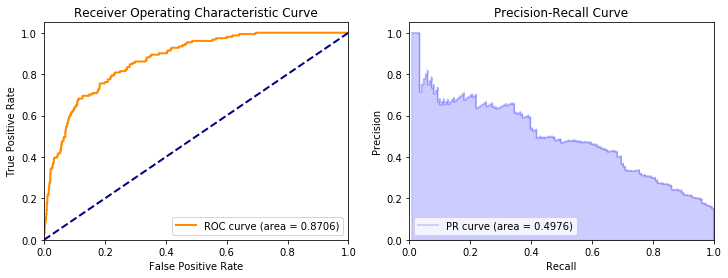

In [63]:
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(lrpredictions, scoreCol='probability', labelCol='indexedLabel')

# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

# We can also get all metrics (FPR, Recall and Precision) by threshold
bcm.getMetricsByThreshold().filter('fpr between 0.19 and 0.21').toPandas()

# And get the confusion matrix for any threshold we want
bcm.print_confusion_matrix(.415856)

In [68]:
bcm.getMetricsByThreshold().filter('fpr between 0.1 and 0.2').toPandas()

,threshold,fpr,recall,precision
0,0.176509,0.100082,0.635762,0.440367
1,0.176173,0.100902,0.635762,0.438356
2,0.175253,0.100902,0.642384,0.440909
3,0.173614,0.101723,0.642384,0.438914
4,0.173420,0.102543,0.642384,0.436937
5,0.169668,0.103363,0.642384,0.434978
6,0.169197,0.104184,0.642384,0.433036
7,0.169061,0.104184,0.649007,0.435556
8,0.168472,0.105004,0.649007,0.433628
9,0.168361,0.105824,0.649007,0.431718


In [78]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

['no', 'yes']
Confusion matrix, without normalization
[[1193   26]
 [ 100   51]]


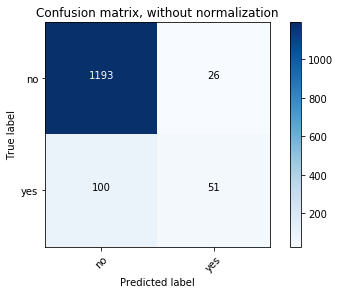

In [80]:
# confusion matrix
from sklearn.metrics import confusion_matrix
class_temp = lrpredictions.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
print(class_temp)
#print(class_names)

y_true = lrpredictions.select("label")
y_true = y_true.toPandas()

y_pred = lrpredictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.97867104 0.02132896]
 [0.66225166 0.33774834]]


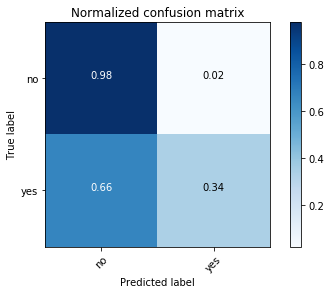

In [82]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Multinomial logistic regression

In [83]:
df2 = spark.read.format('com.databricks.spark.csv') \
            .options(header='true', inferschema='true') \
            .load("WineData2.csv",header=True);
df2.show(5)
df2.printSchema()

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|  pH|sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4|      5|
|  7.8|    0.88|   0.0|  2.6|    0.098|25.0| 67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|  7.8|    0.76|  0.04|  2.3|    0.092|15.0| 54.0|  0.997|3.26|     0.65|    9.8|      5|
| 11.2|    0.28|  0.56|  1.9|    0.075|17.0| 60.0|  0.998|3.16|     0.58|    9.8|      6|
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4|      5|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows

root
 |-- fixed: double (nullable = true)
 |-- volatile: double (nullable = true)
 |-- citric: double (nullable = true)
 |-- sugar: double (nullable = true)
 |-- chl

In [85]:
# Convert to float format
def string_to_float(x):
    return float(x)
#
def condition(r):
    if (0<= r <= 4):
        label = "low"
    elif(4< r <= 6):
        label = "medium"
    else:
        label = "high"
    return label

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType
string_to_float_udf = udf(string_to_float, DoubleType())
quality_udf = udf(lambda x: condition(x), StringType())

df2 = df2.withColumn("quality", quality_udf("quality"))

df2.show(5,True)
df2.printSchema()

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|  pH|sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
|  7.8|    0.88|   0.0|  2.6|    0.098|25.0| 67.0| 0.9968| 3.2|     0.68|    9.8| medium|
|  7.8|    0.76|  0.04|  2.3|    0.092|15.0| 54.0|  0.997|3.26|     0.65|    9.8| medium|
| 11.2|    0.28|  0.56|  1.9|    0.075|17.0| 60.0|  0.998|3.16|     0.58|    9.8| medium|
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows

root
 |-- fixed: double (nullable = true)
 |-- volatile: double (nullable = true)
 |-- citric: double (nullable = true)
 |-- sugar: double (nullable = true)
 |-- chl

In [86]:
# Deal with categorical data and Convert the data to dense vector get_dummy() function

from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

transformed = transData(df2)
transformed.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
|[11.2,0.28,0.56,1...|medium|
|[7.4,0.7,0.0,1.9,...|medium|
+--------------------+------+
only showing top 5 rows



In [87]:
# Deal with Categorical Label and Variables
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)

+--------------------+------+------------+
|            features| label|indexedLabel|
+--------------------+------+------------+
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
|[7.8,0.88,0.0,2.6...|medium|         0.0|
|[7.8,0.76,0.04,2....|medium|         0.0|
|[11.2,0.28,0.56,1...|medium|         0.0|
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
+--------------------+------+------------+
only showing top 5 rows



In [88]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)

+--------------------+------+--------------------+
|            features| label|     indexedFeatures|
+--------------------+------+--------------------+
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|medium|[7.8,0.88,0.0,2.6...|
|[7.8,0.76,0.04,2....|medium|[7.8,0.76,0.04,2....|
|[11.2,0.28,0.56,1...|medium|[11.2,0.28,0.56,1...|
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
+--------------------+------+--------------------+
only showing top 5 rows



In [89]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.7, 0.3])

trainingData.show(5,False)
testData.show(5,False)

+---------------------------------------------------------+------+
|features                                                 |label |
+---------------------------------------------------------+------+
|[4.9,0.42,0.0,2.1,0.048,16.0,42.0,0.99154,3.71,0.74,14.0]|high  |
|[5.0,0.38,0.01,1.6,0.048,26.0,60.0,0.99084,3.7,0.75,14.0]|medium|
|[5.0,0.4,0.5,4.3,0.046,29.0,80.0,0.9902,3.49,0.66,13.6]  |medium|
|[5.0,0.74,0.0,1.2,0.041,16.0,46.0,0.99258,4.01,0.59,12.5]|medium|
|[5.0,1.02,0.04,1.4,0.045,41.0,85.0,0.9938,3.75,0.48,10.5]|low   |
+---------------------------------------------------------+------+
only showing top 5 rows

+----------------------------------------------------------+------+
|features                                                  |label |
+----------------------------------------------------------+------+
|[4.6,0.52,0.15,2.1,0.054,8.0,65.0,0.9934,3.9,0.56,13.1]   |low   |
|[4.7,0.6,0.17,2.3,0.058,17.0,106.0,0.9932,3.85,0.6,12.9]  |medium|
|[5.0,0.42,0.24,2.0,0.06,19.0,50

In [90]:
# Fit Multinomial logisticRegression Classification Model
from pyspark.ml.classification import LogisticRegression
mlr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [96]:
# Chain indexers and mlr in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, mlr,labelConverter])

# Train model.  This also runs the indexers.
mlrmodel = pipeline.fit(trainingData)

In [97]:
# Make predictions.
mlrpredictions = mlrmodel.transform(testData)
# Select example rows to display.
mlrpredictions.select("features","label","predictedLabel","probability").show(5, False)

+----------------------------------------------------------+------+--------------+--------------------------------------------------------------+
|features                                                  |label |predictedLabel|probability                                                   |
+----------------------------------------------------------+------+--------------+--------------------------------------------------------------+
|[4.6,0.52,0.15,2.1,0.054,8.0,65.0,0.9934,3.9,0.56,13.1]   |low   |medium        |[0.796374292926433,0.18857259775937768,0.01505310931418931]   |
|[4.7,0.6,0.17,2.3,0.058,17.0,106.0,0.9932,3.85,0.6,12.9]  |medium|medium        |[0.9055645852397829,0.08284669482699684,0.011588719933220193] |
|[5.0,0.42,0.24,2.0,0.06,19.0,50.0,0.9917,3.72,0.74,14.0]  |high  |high          |[0.29186361309747944,0.7056949905616936,0.0024413963408269996]|
|[5.1,0.51,0.18,2.1,0.042,16.0,101.0,0.9924,3.46,0.87,12.9]|high  |medium        |[0.7057560968644517,0.29069014234068175,0.

In [99]:
#Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(mlrpredictions)
print("Accuracy = %g" % accuracy)

trainingSummary = mlrmodel.stages[2].summary


Accuracy = 0.852823


[0.9625137816979051, 0.3221476510067114, 0.06382978723404255]

Confusion matrix, without normalization
[[395  15   2]
 [ 40  28   0]
 [ 15   1   0]]


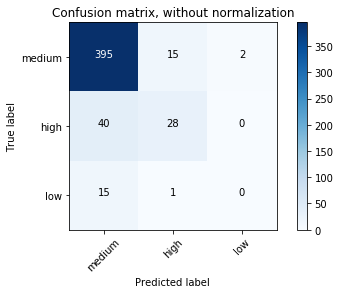

In [107]:
class_temp = mlrpredictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)

from sklearn.metrics import confusion_matrix
y_true = mlrpredictions.select("label")
y_true = y_true.toPandas()

y_pred = mlrpredictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.95873786 0.03640777 0.00485437]
 [0.58823529 0.41176471 0.        ]
 [0.9375     0.0625     0.        ]]


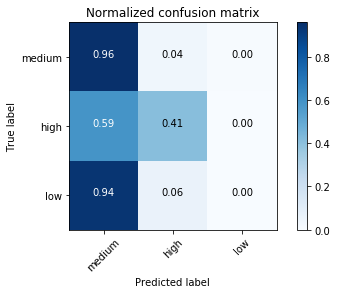

In [108]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Decision tree Classification

In [172]:
df2.show(5, False)
transformed.show(5, False)  #features has data ready in vector format with features and label

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|pH  |sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|7.4  |0.7     |0.0   |1.9  |0.076    |11.0|34.0 |0.9978 |3.51|0.56     |9.4    |medium |
|7.8  |0.88    |0.0   |2.6  |0.098    |25.0|67.0 |0.9968 |3.2 |0.68     |9.8    |medium |
|7.8  |0.76    |0.04  |2.3  |0.092    |15.0|54.0 |0.997  |3.26|0.65     |9.8    |medium |
|11.2 |0.28    |0.56  |1.9  |0.075    |17.0|60.0 |0.998  |3.16|0.58     |9.8    |medium |
|7.4  |0.7     |0.0   |1.9  |0.076    |11.0|34.0 |0.9978 |3.51|0.56     |9.4    |medium |
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows

+-----------------+
|features         |
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
+----

In [173]:
# Index labels, to indexedLabel
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, False)

IllegalArgumentException: 'Field "label" does not exist.\nAvailable fields: features'

In [165]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                            outputCol="indexedFeatures", \
                            maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, False)

+--------------------------------------------------------+------+--------------------------------------------------------+
|features                                                |label |indexedFeatures                                         |
+--------------------------------------------------------+------+--------------------------------------------------------+
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |medium|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |
|[7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8]  |medium|[7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8]  |
|[7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8] |medium|[7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8] |
|[11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8]|medium|[11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8]|
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |medium|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |
+---------------

In [116]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.7, 0.3])
trainingData.show(5,False)
testData.show(5)

+---------------------------------------------------------+------+
|features                                                 |label |
+---------------------------------------------------------+------+
|[4.7,0.6,0.17,2.3,0.058,17.0,106.0,0.9932,3.85,0.6,12.9] |medium|
|[4.9,0.42,0.0,2.1,0.048,16.0,42.0,0.99154,3.71,0.74,14.0]|high  |
|[5.0,0.38,0.01,1.6,0.048,26.0,60.0,0.99084,3.7,0.75,14.0]|medium|
|[5.0,0.4,0.5,4.3,0.046,29.0,80.0,0.9902,3.49,0.66,13.6]  |medium|
|[5.0,0.42,0.24,2.0,0.06,19.0,50.0,0.9917,3.72,0.74,14.0] |high  |
+---------------------------------------------------------+------+
only showing top 5 rows

+--------------------+------+
|            features| label|
+--------------------+------+
|[4.6,0.52,0.15,2....|   low|
|[5.0,1.02,0.04,1....|   low|
|[5.1,0.47,0.02,1....|medium|
|[5.2,0.34,0.0,1.8...|medium|
|[5.2,0.49,0.26,2....|medium|
+--------------------+------+
only showing top 5 rows



In [117]:
#build decisiontree classifier
from pyspark.ml.classification import DecisionTreeClassifier
# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree,labelConverter])

# Train model.  This also runs the indexers.
dtmodel = pipeline.fit(trainingData)

In [121]:
# Make predictions.
dtpredictions = dtmodel.transform(testData)
# Select example rows to display.
dtpredictions.select("features","label","predictedLabel","probability",'indexedLabel','prediction').show(5)

+--------------------+------+--------------+--------------------+------------+----------+
|            features| label|predictedLabel|         probability|indexedLabel|prediction|
+--------------------+------+--------------+--------------------+------------+----------+
|[4.6,0.52,0.15,2....|   low|        medium|[0.88709677419354...|         2.0|       0.0|
|[5.0,1.02,0.04,1....|   low|        medium|[0.73333333333333...|         2.0|       0.0|
|[5.1,0.47,0.02,1....|medium|          high|[0.38235294117647...|         0.0|       1.0|
|[5.2,0.34,0.0,1.8...|medium|          high|[0.38235294117647...|         0.0|       1.0|
|[5.2,0.49,0.26,2....|medium|          high|[0.38235294117647...|         0.0|       1.0|
+--------------------+------+--------------+--------------------+------------+----------+
only showing top 5 rows



In [120]:
dtpredictions.columns

['features',
 'label',
 'indexedLabel',
 'indexedFeatures',
 'rawPrediction',
 'probability',
 'prediction',
 'predictedLabel']

In [123]:
#Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(dtpredictions)
print("Accuracy = %g" % accuracy)

rfModel = dtmodel.stages[-2]
print(rfModel)  # summary only

Accuracy = 0.822917
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_eb2d570f78b7) of depth 5 with 43 nodes


In [126]:
class_temp = dtpredictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_temp

['medium', 'high', 'low']

In [127]:
from sklearn.metrics import confusion_matrix
y_true = dtpredictions.select("label")
y_true = y_true.toPandas()

y_pred = dtpredictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[370,  17,   3],
       [ 44,  25,   0],
       [ 21,   0,   0]], dtype=int64)

Confusion matrix, without normalization
[[370  17   3]
 [ 44  25   0]
 [ 21   0   0]]


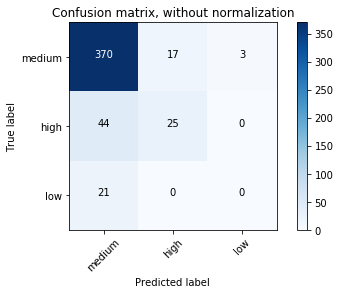

In [129]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

## Random forest Classification

In [130]:
df2.show(5)
transformed.show(5)
trainingData.show(5)
testData.show(5)

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|  pH|sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
|  7.8|    0.88|   0.0|  2.6|    0.098|25.0| 67.0| 0.9968| 3.2|     0.68|    9.8| medium|
|  7.8|    0.76|  0.04|  2.3|    0.092|15.0| 54.0|  0.997|3.26|     0.65|    9.8| medium|
| 11.2|    0.28|  0.56|  1.9|    0.075|17.0| 60.0|  0.998|3.16|     0.58|    9.8| medium|
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04

In [133]:
# creat randonforest classifier class
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

# Train model.  This also runs the indexers.
rfmodel = pipeline.fit(trainingData)

In [134]:
# Make predictions.
rfpredictions = rfmodel.transform(testData)
# Select example rows to display.
rfpredictions.select("features","label","predictedLabel","probability",'indexedLabel','prediction').show(5)

+--------------------+------+--------------+--------------------+------------+----------+
|            features| label|predictedLabel|         probability|indexedLabel|prediction|
+--------------------+------+--------------+--------------------+------------+----------+
|[4.6,0.52,0.15,2....|   low|        medium|[0.80958790124566...|         2.0|       0.0|
|[5.0,1.02,0.04,1....|   low|        medium|[0.82962214950994...|         2.0|       0.0|
|[5.1,0.47,0.02,1....|medium|        medium|[0.56418714507701...|         0.0|       0.0|
|[5.2,0.34,0.0,1.8...|medium|        medium|[0.65904329897794...|         0.0|       0.0|
|[5.2,0.49,0.26,2....|medium|        medium|[0.69647145113421...|         0.0|       0.0|
+--------------------+------+--------------+--------------------+------------+----------+
only showing top 5 rows



In [135]:
# Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(rfpredictions)
print("Accuracy = %g" % accuracy)

rfModel = rfmodel.stages[-2]
print(rfModel)  # summary only

Accuracy = 0.833333
RandomForestClassificationModel (uid=RandomForestClassifier_03d95325bed8) with 100 trees


In [137]:
#confusion matrix
class_temp = rfpredictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)

from sklearn.metrics import confusion_matrix
y_true = rfpredictions.select("label")
y_true = y_true.toPandas()

y_pred = rfpredictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[386,   4,   0],
       [ 55,  14,   0],
       [ 21,   0,   0]], dtype=int64)

Confusion matrix, without normalization
[[386   4   0]
 [ 55  14   0]
 [ 21   0   0]]


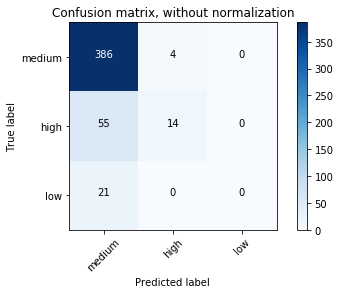

In [138]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

## Gradient-boosted tree Classification
only support binary classification

In [152]:
df.show(5)
data.show(5)
trainingData1.show(5)
testData1.show(5)

+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+
|age|        job|marital|education|default|balance|housing|loan| contact|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+
| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular|      79|       1|   -1|       0| unknown| no|
| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular|     220|       1|  339|       4| failure| no|
| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular|     185|       1|  330|       1| failure| no|
| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|     199|       4|   -1|       0| unknown| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no| unknown|     226|       1|   -1|       0| unknown| no|
+---+-----------+-------+---------+-----

In [153]:
# creat GBT classifier class, only support binary classification
from pyspark.ml.classification import GBTClassifier

# Train a RandomForest model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer1, featureIndexer1, gbt,labelConverter1])

# Train model.  This also runs the indexers.
gbtmodel = pipeline.fit(trainingData1)

In [154]:
# Make predictions.
gbtpredictions = gbtmodel.transform(testData1)
# Select example rows to display.
gbtpredictions.select("features","label","predictedLabel","probability",'indexedLabel','prediction').show(5)

+--------------------+-----+--------------+--------------------+------------+----------+
|            features|label|predictedLabel|         probability|indexedLabel|prediction|
+--------------------+-----+--------------+--------------------+------------+----------+
|(29,[0,11,13,16,1...|   no|            no|[0.95560085795900...|         0.0|       0.0|
|(29,[0,11,13,16,1...|   no|            no|[0.82121067051625...|         0.0|       0.0|
|(29,[0,11,13,16,1...|   no|            no|[0.94727608552159...|         0.0|       0.0|
|(29,[0,11,13,16,1...|   no|            no|[0.95554789392338...|         0.0|       0.0|
|(29,[0,11,13,16,1...|   no|            no|[0.79058364575712...|         0.0|       0.0|
+--------------------+-----+--------------+--------------------+------------+----------+
only showing top 5 rows



In [155]:
# Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(gbtpredictions)
print("Accuracy = %g" % accuracy)

gbtModel = gbtmodel.stages[-2]
print(gbtModel)  # summary only

Accuracy = 0.884111
GBTClassificationModel (uid=GBTClassifier_a99ffc982bae) with 20 trees


Confusion matrix, without normalization
[[1164   43]
 [ 116   49]]


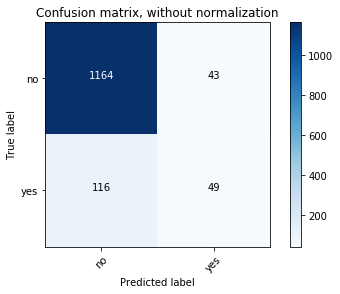

In [156]:
#confusion matrix
class_temp = gbtpredictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)

from sklearn.metrics import confusion_matrix
y_true = gbtpredictions.select("label")
y_true = y_true.toPandas()

y_pred = gbtpredictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

## Naive Bayes Classification

In [157]:
df2.show(5)
transformed.show(5)
trainingData.show(5)
testData.show(5)

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|  pH|sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
|  7.8|    0.88|   0.0|  2.6|    0.098|25.0| 67.0| 0.9968| 3.2|     0.68|    9.8| medium|
|  7.8|    0.76|  0.04|  2.3|    0.092|15.0| 54.0|  0.997|3.26|     0.65|    9.8| medium|
| 11.2|    0.28|  0.56|  1.9|    0.075|17.0| 60.0|  0.998|3.16|     0.58|    9.8| medium|
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04

In [158]:
# creat NB classifier class
from pyspark.ml.classification import NaiveBayes

# Train a RandomForest model.
NB = NaiveBayes(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, NB,labelConverter])

# Train model.  This also runs the indexers.
nbmodel = pipeline.fit(trainingData)

In [159]:
# Make predictions.
nbpredictions = nbmodel.transform(testData)
# Select example rows to display.
nbpredictions.select("features","label","predictedLabel","probability",'indexedLabel','prediction').show(5)

+--------------------+------+--------------+--------------------+------------+----------+
|            features| label|predictedLabel|         probability|indexedLabel|prediction|
+--------------------+------+--------------+--------------------+------------+----------+
|[4.6,0.52,0.15,2....|   low|        medium|[0.99566858445328...|         2.0|       0.0|
|[5.0,1.02,0.04,1....|   low|        medium|[0.99997091990508...|         2.0|       0.0|
|[5.1,0.47,0.02,1....|medium|        medium|[0.93771024371608...|         0.0|       0.0|
|[5.2,0.34,0.0,1.8...|medium|        medium|[0.99577137416038...|         0.0|       0.0|
|[5.2,0.49,0.26,2....|medium|        medium|[0.99944773183233...|         0.0|       0.0|
+--------------------+------+--------------+--------------------+------------+----------+
only showing top 5 rows



In [161]:
# Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(nbpredictions)
print("Accuracy = %g" % accuracy)

nbModel = nbmodel.stages[-2]
print(nbModel)  # summary only

Accuracy = 0.629167
NaiveBayes_2d33446c062e


Confusion matrix, without normalization
[[264 125   1]
 [ 31  38   0]
 [  9  12   0]]


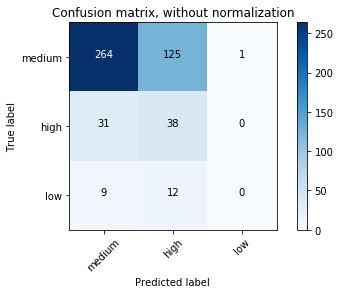

In [162]:
#confusion matrix
class_temp = nbpredictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)

from sklearn.metrics import confusion_matrix
y_true = nbpredictions.select("label")
y_true = y_true.toPandas()

y_pred = nbpredictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()